**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

The second package we are installing is [pymatsolver](https://github.com/rowanc1/pymatsolver), which interfaces to sparse matrix solvers. It is not required for the tutorial, we will fall-back to an LU solver, which is sufficient for this problem 

In [1]:
# !pip install SimPEG
# !pip install pymatsolver

# Inversion: 1D Magnetotelluric Problem

In the previous notebooks, we explored how to discretize the [1D MT problem](./1_MT1D_NumericalSetup.ipynb), how to design an appropriate mesh, and explored the [an example of non-uniquness](./2_MT1D_ForwardModellingAndNonuniqueness.ipynb). In this notebook, we will put those concepts to use and set up a 1D inversion. 

The aim of this notebook is to highlight the elements we use to set up and solve the inverse problem, in the notebook that follows this, we will dive futher into the impact of various parameter choices (eg. the trade-off parameter $\beta$, the stopping criteria, noise model and regulariztion parameters). 

## Inversion as Optimization

We will use deterministic approach and pose the inverse problem as an optimization problem of the form 

$$
\min_{\mathbf{m}} \phi(\mathbf{m}) = \phi_d(\mathbf{m}) + \beta\phi_m(\mathbf{m})
$$

where:
- $\mathbf{m}$ is our model - the vector of numbers that describes our earth model. It is what we are solving for in the inversion
- $\phi_d(\mathbf{m})$ is the data misfit
- $\phi_m(\mathbf{m})$ is the regularization
- $\beta$ is a trade-off parameter

### Data Misfit

The data misfit, $\phi_d(\mathbf{m})$, is often taken to be a weighted $\ell_2$-norm, where the weights capture the noise model (eg. we want to assign higher weights and do a good job fitting data that we are confident are less noisy, and assign less weight / influence to data that are noisy). The $\ell_2$ norm is the correct norm to choose when noise is Gaussian (or approximately Gaussian, or if you have no additional information and assume it is Gaussian). An $\ell_2$ data misfit is captured mathematically by  

$$
\phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) - \mathbf{d}^{\text{obs}})\|^2
$$

where 

- $\mathbf{W_d} = \text{diag}(1/\boldsymbol{\epsilon})$ is a diagonal matrix with diagonal entries $1/\epsilon_i$, where $\epsilon_i$ is an estimated standard deviation of the $i$th datum.
- $\mathcal{F}$ is the forward modelling operator that simulates the 1D MT response given a model
- $\mathbf{m}$ is the model: the set of parameters which describe the physical properties of the layered earth
- $\mathbf{d}^{\text{obs}}$ is the observed data

(The factor of $1/2$ and the choice of using the squared-norm is a matter of convienence. We will be using gradient based optimzation methods, so it is easier to take derivatives of a norm squared than a norm.)

### Regularization
The inverse problem is an [ill posed problem](https://en.wikipedia.org/wiki/Well-posed_problem). There are multiple (actually infinitely many!) models that can fit the data.  There are a couple ways to observe this:

- Mathematically: If we start by thinking about a linear problem $\mathbf{G}\mathbf{m} = \mathbf{d}$, the matrix $\mathbf{G}$ is wide, so it is not directly invertible (eg. see Matt Hall's [Linear Inversion Tutorial](http://library.seg.org/doi/full/10.1190/tle35121085.1)). Here, we are dealing with a non-linear system of equations, but the principle is the same. 

- An Example: In the [Forward Modelling and Nonuniqueness notebook](2_MT1D_ForwardModellingAndNonuniqueness.ipynb), we used forward modelling to demonstrate non-uniquness with the conductivity-thickness product of a single, conductive layer, and this is a very simple model compared to most geologic settings! 

Thus, to choose from the infinitely many solutions and arrive at a sensible one, we employ a regularization: $\phi_m$. Tikhonov regularization, which again employs $\ell_2$-norms, is a standard choice (It has a few nice features: it is convex and easy to differentiate). It takes the form: 
$$
\phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|\mathbf{W_s} (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_z\|\mathbf{W_z} (\mathbf{m})\|^2 \big)
$$

The first term is often referred to as the "smallness" as it measures the "size" of the model (in the $\ell_2$ sense). The matrix $\mathbf{W_s}$ is generally taken to be a diagonal matrix that may contain information about the length scales of the model or be used to weight the relative importance of various parameters in the model. The scalar $\alpha_s$ weights the relative importance of this term in the regularization. Notice that we include a reference model ($\mathbf{m}_{\text{ref}}$. Often this is defined as a constant value, but if more information is known about the background, that can be used to construct a reference model. Note that saying "I am not going to use a reference model" means that you are actually using $\mathbf{m}_{\text{ref}} = 0$, this is important to realize... in the inversion we demonstrate here, our `model` will be $\mathbf{m} = \text{log}(\sigma)$. If we set $\mathbf{m}_{\text{ref}} = 0$, then we are favoring models close to 1 S/m - which is quite conductive! 

The second term is often referred to as the "smoothness". The matrix $\mathbf{W_z}$ approximate the derivative of the model with respect to depth, and is hense a measure of how "smooth" the model is. The term $\alpha_z$ weights its relative importance in the regularization. 


## In this notebook...

Although we pose the inverse problem as an optimization problem, we aren't necessarily going to solve to a true minimum. There are always uncertainties with the data, so there is no point trying to drive $\phi_d$ to its true minimium - we would end up introducing structures in the model to fit the data (we will explore this here). So another choice that has to be made when setting up an inversion is where to stop. 

In this notebook, we will walk through how to set up an inversion and discuss one of the knobs:
- The $\beta$ knob: How well should we fit the data verses the regularization? Which $\beta$ value provides us the right balance? eg. When do we achieve the target misfit $\phi_d^*$?
- The $\alpha$ knob: Tuning the **regularization** ($\alpha_s$, $\alpha_z$): how _smooth_ or _small_ (in the $\ell_2$-sense) do we want our model to be?

We will also point out other parameters you can explore the impact of, including, 
- starting model $\mathbf{m}_0$
- reference model $\mathbf{m}_{\text{ref}}$
- designing a $\beta$-cooling schedule

In the [next notebook](./4_MT1D_5layer_inversion.ipynb) we will dive further into the $\alpha$ knob. 

**A Note**

We will employ second-order optimization methods, meaning we have to be able to both simulate data and compute derivatives. We will take those steps for granted in this notebook, but if you are curious to look under the hood and see how sensitivities are computed for this problem, have a look at the [Sensitivities Notebook](./Appendix_A_MT1D_Sensitivity.ipynb).  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from SimPEG import (
    Mesh, Maps, SolverLU, DataMisfit, Regularization,
    Optimization, InvProblem, Inversion, Directives, Utils
)

try:
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as Solver

# the following are described in the Sensitivity notebooks
from MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx

%matplotlib inline

## Forward Simulation

### Parmeters
Now, we define our model parameters and survey setup. This includes defining
- location of receivers
- frequencies we are sampling
- type of dat we are measuring (impedance or apparent resistivity and phase)

Similar to the model shown in [1_MT1D_NumericalSetup.ipynb](./1_MT1D_NumericalSetup.ipynb) and [2_MT1D_ForwardModellingAndNonuniqueness](./2_MT1D_ForwardModellingAndNonuniqueness.ipynb), we will start by considering a simple model which consists of 2 units: the background and a conductive layer (the layer). 

In [3]:
rho_half = 100.  # resistivity of the half space
rho_target = 10.  # resistivity of the target layer
depth = 2000.  # depth to the top of the target layer
thickness = 1000.   # thickness of the target layer

In [4]:
rxloc = np.r_[0.]   
frequency = np.logspace(-3, 2, 25)

### Survey
Next, we set up a `survey` object. Here we are following the SimPEG approach and define 
- a receiver object: given fields found from a simulation, it has the machinery to compute data. An impedance receiver `ZxyRx` calculates the ratio of $E_x$ and $H_y$ from calculated electric and magnetic fields (both real and imaginary components)
- a source object: this provides the right-hand-side for our MT problem. This is a plane wave source with at the specified frequency. 

These are combined in a `survey`. 

In [5]:
# Create a receiver object 
rx = ZxyRx(
    rxloc, # location of the receiver 
    component="both",  # measure both the real and imaginary components of the impedance (alternatively "real" / "imag")
    frequency=frequency
)

# create a plane wave source
src = MT1DSrc([rx])

# define a survey
survey = MT1DSurvey([src])

### Mesh

In the [Forward Modelling and Nonuniqueness notebook](2_MT1D_ForwardModellingAndNonuniqueness.ipynb), we discussed how to design a mesh that extends sufficiently far and has fine enough cells near the surface to accurately simulate the MT response across the frequency range of interest. We have wrapped up that knowledge in the utility function `setMesh` 

In [6]:
max_depth_core = 5000.
mesh = survey.setMesh(
    sigma=1./rho_half,  # conductivity of the background
    max_depth_core=max_depth_core,  # extent of the core region of the mesh
    ncell_per_skind=10,  # number of cells per the smallest skin depth
    n_skind=2,  # number of skin depths that the mesh should extend to ensure the lowest-frequency fields have decayed
    core_meshType = "linear",  # cell spacings in the core region of the mesh ("linear" or "log")
    max_hz_core=None  # If using a logarithmic core mesh, what is the maximum cell size?
)

>> Smallest cell size = 50 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 100


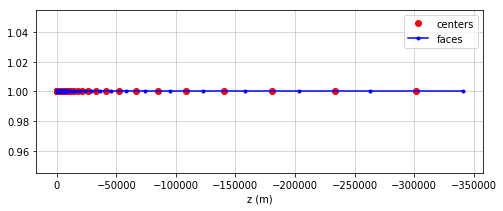

In [7]:
# plot the mesh
fig, ax = plt.subplots(1,1, figsize=(8, 3))
mesh.plotGrid(centers=True, faces=True, ax=ax)
ax.legend(["centers", "faces"])
ax.invert_xaxis()  # so that the surface is on our left hand side
ax.set_xlabel('z (m)')
ax.grid(which="both", linewidth=0.5)

### Problem

In the previous notebooks, we set up the machinery to solve the 1D MT problem. Here, we will use that functionality. Please see [Sensitivities Notebook](./3_MT1D_Sensitivity.ipynb) for further discussion on how `MT1DProblems` is set up. 

In [8]:
prob = MT1DProblem(
    mesh,  # The mesh contains the geometry, grids, etc necessary for constructing the discrete PDE system
    sigmaMap=Maps.ExpMap(mesh),  # in the inversion, we want to invert for log-conductivity (enforces postivity, electrical conductivity tends to vary logarithmically)
    verbose=False,  # print information as we are setting up and solving 
    Solver=Solver  # solver to employ for solving Ax = b
)

# tell the problem and survey about each other so we can construct our matrix system 
# and right hand-side
prob.pair(survey)

### Put the model on the mesh

Physical properties are defined at cell centers, so there should be a `sigma` value for every cell center. Above, we defined our model as resisvitities (in units of $\Omega m$), but for the inversion, we want to work in conductivities (in units of S/m), so we take the reciprocal ($\sigma = 1/\rho$)

In [9]:
sigma = np.ones(mesh.nC) * 1./rho_half

# find the layer
layer_inds = (mesh.vectorCCx<-depth)&(mesh.vectorCCx>-depth-thickness)
sigma[layer_inds] = 1./rho_target

(0, -5000.0)

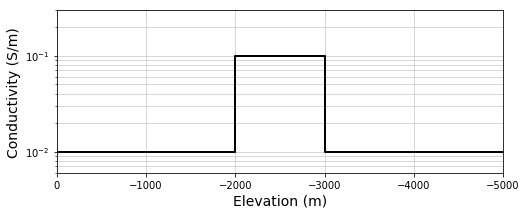

In [10]:
# plot the model
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

# trickery to plot from node to node rather than at cell centers
z = np.repeat(mesh.vectorNx[1:-1], 2, axis=0)
z = np.r_[mesh.vectorNx[0], z, mesh.vectorNx[-1]]
sigma_plt = np.repeat(sigma, 2, axis=0)

ax.semilogy(z, sigma_plt, "k", lw=2)
ax.invert_xaxis() # plot the surface on the left
ax.set_xlabel("Elevation (m)", fontsize=14)
ax.set_ylabel("Conductivity (S/m)", fontsize=14)
plt.grid(which='both', linewidth=0.5)
plt.ylim(6e-3, 3e-1)
plt.xlim(0, -max_depth_core)

## Simulate 'Observed' Data

Based on the conductivity structure plotted above, we will create synthetic data. These data will later be used in the inversion. 

In the inversion, the "model" that we will invert for is in $\log(\sigma)$. There are a couple of reasons for this: the electrical conductivity of earth materials can vary over several orders of magnitude, and electrical conductivity is always positive, so inverting for $\log(\sigma)$ enforces that. 

In SimPEG, the method `dpred` of the `survey` class solves the PDE and computes the data required by the receivers. 

In [11]:
mtrue = np.log(sigma)  # since our "model" is log conductivity, we take the log
dtrue = survey.dpred(mtrue)  # these are clean data (no noise yet.)

Add noise to generate "observed" data

In [28]:
np.random.seed(1)  # set a seed to the results are reproducable
std = 0.1  # standard deviation of the noise (10%)

# add noise
uncert = std * np.abs(dtrue)
noise = uncert * np.random.randn(survey.nFreq*2)
survey.dobs = dtrue + noise

In [29]:
# data are arranged (apparent resistivity, phase) for each frequency
Zxy_real_true = dtrue.reshape((survey.nFreq, 2))[:,0]
Zxy_imag_true = dtrue.reshape((survey.nFreq, 2))[:,1]

Zxy_real_obs = survey.dobs.reshape((survey.nFreq, 2))[:,0]
Zxy_imag_obs = survey.dobs.reshape((survey.nFreq, 2))[:,1]

Although we will work with real and impaginary impedance values as our data in the inversion, it is a bit more intuitive to plot the data in terms of apparent resistivity (which hase units of resistivity, $\Omega m$) and phase

$$
\rho_a = \frac{1}{\mu_0\omega} \big|Z_{xy}\big|^2
$$

$$
\phi = \tan^{-1}\left(\frac{\text{Im}(Z_{xy})}{\text{Re}(Z_{xy})}\right)
$$


In [30]:
def omega(frequency):
    """
    angular frequency
    """
    return 2*np.pi*frequency

def app_res_phase(Zxy_real, Zxy_imag, frequency):
    """
    Compute apparent resistivity and phase given impedances (real and imaginary components)
    and the frequency. 
    """
    app_res = abs(Zxy_real+1j*Zxy_imag)**2 / (mu_0*omega(frequency))
    phase = np.rad2deg(np.arctan(Zxy_imag / Zxy_real))
    return app_res, phase

In [31]:
# fetch the apparent resistivity and phase for the clean (true) and noisy (obs) data
app_res_true, phase_true = app_res_phase(Zxy_real_true, Zxy_imag_true, frequency)
app_res_obs, phase_obs = app_res_phase(Zxy_real_obs, Zxy_imag_obs, frequency)

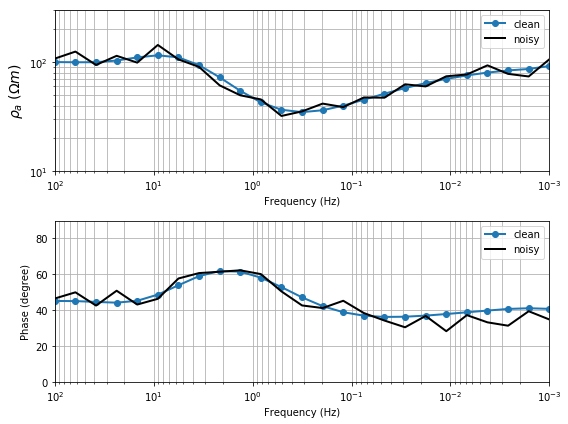

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))

# apparent resistivity
ax[0].loglog(frequency, app_res_true, '-o', lw=2, label="clean")
ax[0].loglog(frequency, app_res_obs, 'k-', lw=2, label="noisy")
ax[0].set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)
ax[0].set_ylim([10, 3e2])

# phase
ax[1].semilogx(frequency, phase_true, '-o', lw=2, label="clean")
ax[1].semilogx(frequency, phase_obs, 'k-', lw=2, label="noisy")
ax[1].set_ylabel("Phase (degree)")
ax[1].set_ylim([0, 90])

for a in ax:
    a.grid(True, which='both')
    a.legend()
    a.set_xlim(frequency.max(), frequency.min())
    a.set_xlabel("Frequency (Hz)")

plt.tight_layout()

## Inverse Problem: Machinery

Our setup of the inversion follows the [SimPEG framework](http://simpeg.xyz).  

<img href="http://simpeg.xyz" src="http://www.simpeg.xyz/img/simpeg/workflow.png" width=400px>

The "inversion implementation" consists of 8 modules, 3 of which we have already been working with. This is a very brief overview. For more details, see the [SimPEG docs](http://docs.simpeg.xyz)

- `Mesh`: mesh geometry and differential operators
- `Problem`: physics engine. contains the machinery to construct and solve the PDE
- `Survey`: sources and receivers
- `Data Misfit`: measure of how "far" the predicted data are from the observed data
- `Regularization`: Regularization on the model. Here we use Tikhonov regularization
- `InvProb`: statement of the inverse problem, brings together the data misfit and regularization to define an objective function that we minimize in the inversion
- `Optimization`: algorithm we will use to perform the optimization in the inversion, here, we choose a gradient based approach
- `Inversion`: Bring everything together to run the inversion. This includes `directives` which are instructions on updates that should be made during the course of the inversion (eg. cooling beta) and stopping criteria (eg. target misfit)

In [33]:
def run_MT1Dinv(
    prob,  # 1D MT problem
    survey,  # 1D MT survey with sources and receivers
    mref,  # reference model
    m0 = None,  # starting model
    alpha_s=1.,  # smallness weight
    alpha_z=1.,  # smoothness weight
    beta0=1e1,  # trade off parameter
    coolingFactor=1.5,  # cooling factor 
    coolingRate=1,  # cool beta after this many iterations 
    use_target=True,  # stop the inversion at the target misfit?
    use_betaest=False,  # estimate an initial beta based on the the data misfit and regularization terms
    beta0_ratio=None  # if we are estimating beta, how much should we favor the regularization?
):
    # if the starting model is not defined, use the reference model
    if m0 is None:
        m0 = mref
    
    # Data misfit
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    
    # Regularization
    reg = Regularization.Simple(prob.mesh, alpha_s=alpha_s, alpha_x=alpha_z) # since we are in 1D, we work with the first dimension
    
    # Optimization
    opt = Optimization.InexactGaussNewton(maxIter=35, LSshorten=0.05)
    
    # Statement of the inverse problem 
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    
    # Inversion Directives
    beta = Directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    invProb.beta = beta0
    save = Directives.SaveOutputEveryIteration(save_txt=False)
    target = Directives.TargetMisfit()
    directives = [beta, save]

    if use_target:
        directives.append(target)
    if use_betaest:
        if beta0_ratio is None:
            beta0_ratio = 1.
        betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
        directives.append(betaest)      
        
    # assemble in an inversion
    inv = Inversion.BaseInversion(invProb, directiveList=directives)
    prob.counter = opt.counter = Utils.Counter()
    opt.remember('xc')
    
    # run the inversion
    mopt = inv.run(m0)
    xc = opt.recall("xc")
    return xc, save, reg

## Inverse Problem: Choices

### Target Misfit and the ideal $\beta$

If the noise is Gaussian, then the sum of squares (our data misfit) is a Chi-squared distribution, which has an expected value of $N_\text{data}$ (in our case, we divide this by two to match our definition of $\phi_d$). Thus, the ideal choice of $\beta$ is one that gives us 
$$\phi_d^* \approx \frac{1}{2} N_\text{data}$$

You can choose to stop the inversion once it achieves the target misfit (`use_target=True`). For this example, we want to also demonstrate what happens when you over-fit the data, so we will not stop it at the target misfit, but run the inversion until it hits the maximum number of iterations. 

#### A (longish) note: $\beta$ cooling
In this example, we will run an inversion where we cool (reduce the value of) `beta` every iteration. In practice, `beta` cooling strategy is often applied in non-linear inversions. The data misfit contribution objective function is non-convex, meaning that it has more than one local minimum. The Tikhonov regularization is convex. Having a large `beta` ensures that at least locally, the function is convex, so we can make progress using a gradient-based optimization step. However, keeping `beta` very high means that we do a good job fitting the regularization, and not necessarily fitting the data. Adopting a cooling schedule is one strategy for trying to address these competing challenges: by starting with a large beta and gradually reducing it, we make progress on a locally convex problem and then gradually allow more structure to the model by gradually reducing the value of `beta`. Typically multiple model updates are made for each beta-value (eg. you can increase the `coolingRate` to 3 to have 3 model update steps taken for each value of beta). The `coolingFactor` is the factor by which we reduce beta at the next beta-iteration (eg. `beta[i+1] = beta[i]/coolingFactor`).

The `use_betaest` selects if we estimate a first beta or prescribe it. The directive which estimates the first `beta` value approximates the relative magnitudes of both $\phi_d$ and $\phi_m$ (eg. if $\phi_d \sim 10$ and $\phi_m \sim 1$, then to balance their influence in the objective function, we would choose $\beta = 10$). The `beta_factor` is a scaling factor so that we can specify if we would like the influence of $\phi_m$ to be `beta_factor` times larger than $\phi_d$ (eg. if $\phi_d \sim 10$ and $\phi_m \sim 1$ and we use `beta_factor = 2`, then the initial beta would be 20). 

For the following example, we will gradually reduce $\beta$ at every iteration - this allows us to plot out a "typical" Tikhonov or trade-off curve of $\phi_d$ vs. $\phi_m$. We encourage you to explore different beta-cooling strategies. 


## Regularization and tuning smallness vs. smoothness

Here, we perform a "smooth" inversion, that is, we define $\alpha_s \ll \alpha_z$, and penalize large gradients in the model. What happens if you reverse the values of `alpha_s` and `\alpha_z` and instead perform a "small" inversion?


## Starting and Reference Models

For both a starting and reference model, we use the background conductivity of $10^{-2}$ S/m. Since in the inversion,the model is $\log(\sigma)$, we take the logarithm. What happens when you change these?

In [34]:
sigma_ref = 1e-2  # reference conductivity
sigma_0 = 1e-2  # starting conductivity 

# translate the starting and reference model to log-conductivity
mref = np.log(sigma_ref)*np.ones(mesh.nC)
m0 = np.log(sigma_0)*np.ones(mesh.nC)

xc, save, reg = run_MT1Dinv(
    prob,  
    survey,  
    mref=mref,  # reference model
    m0=m0, # starting model
    alpha_s=1e-2,  # smallness contribution 
    alpha_z=1.,  # smoothness contribution to the regularization
    use_betaest=True, # estimate the initial beta
    beta0_ratio=10,  # starting contribution of regularization 10x larger than the data misfit  
    coolingFactor=1.5,  # how much should we reduce beta at every beta-iteration
    coolingRate=1,  # reduce beta after each `coolingRate` iterations
    use_target=False  # stop the inversion at the target misfit
)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.48e+02  5.03e+02  0.00e+00  5.03e+02    1.24e+02      0              
   1  1.65e+02  8.22e+01  2.94e-01  1.31e+02    1.65e+01      0              
   2  1.10e+02  4.62e+01  4.02e-01  9.05e+01    6.38e+00      0   Skip BFGS  
   3  7.36e+01  3.35e+01  4.77e-01  6.86e+01    4.33e+00      0   Skip BFGS  
   4  4.90e+01  2.68e+01  5.42e-01  5.33e+01    3.09e+00      0   Skip BFGS  
   5  3.27e+01  2.30e+01  5.98e-01  4.25e+01    2.19e+00      0   Skip 

In [20]:
# grab beta, phi_d, phi_m from the inversion. They are lists, so we convert them to arrays
beta = np.array(save.beta)
phi_d = np.array(save.phi_d)
phi_m = np.array(save.phi_m)

# find the iteration where we achieved target misfit
target_misfit = 2 * survey.nFreq / 2.
i_target = 0
while phi_d[i_target] > target_misfit:
    i_target += 1    

### Inversion Progress: What does the $\beta$-knob do?
In the following plots, we show
- $\phi_d$ vs. $\beta$
- $\phi_m$ vs. $\beta$
- $\phi_d$ vs. $\phi_m$

Notice that as $\beta$ decreases, $\phi_d$ decreases and $\phi_m$ increases (as we decrease the importance of the model regularization, we introduce more structure in the model and do a better job fitting the data) 

In all plots, the star indicates the iteration where we achieved target misfit. 

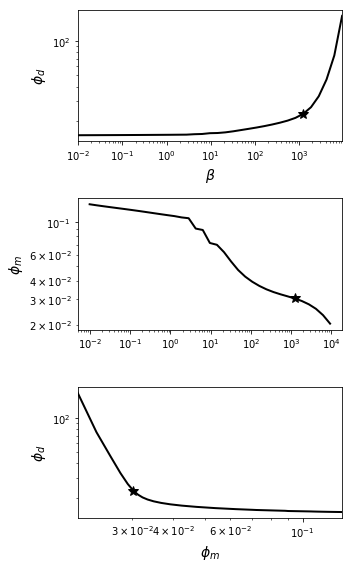

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(5, 8))

# plot phi_d
ax[0].loglog(beta, phi_d, 'k-', lw=2, ms=4)
ax[0].loglog(beta[i_target], phi_d[i_target], 'k*', ms=10)
ax[0].set_ylabel("$\phi_d$", fontsize = 14)

# phi_m
ax[1].loglog(beta, phi_m, 'k-', lw=2)
ax[1].loglog(beta[i_target], phi_m[i_target], 'k*', ms=10)
ax[1].set_ylabel("$\phi_m$", fontsize = 14)

ax[2].loglog(phi_m, phi_d, 'k-', lw=2)
ax[2].loglog(phi_m[i_target], phi_d[i_target], 'k*', ms=10)
ax[2].set_xlim(phi_m.min(), phi_m.max())
ax[2].set_xlabel("$\phi_m$", fontsize = 14)
ax[2].set_ylabel("$\phi_d$", fontsize = 14)

for a in ax[0:1]:
    a.set_xlim(beta.min(), beta.max())
    a.set_xlabel("$\\beta$", fontsize = 14)

plt.tight_layout()

## The results! 

In what follows, we will generate an interactive plots that show 

(a) the true and recovered model
(b) the Tikhonov curve with the target misfit plotted as a star, and the current iteration as a dot
(c) predicted and observed apparent resistivity curve
(d) predicted and observed phase curve

What does our data fit look like at each iteration? Are there biases? When have we underfit the data? overfit the data? Let's scroll through the inversion results and see. 

In [22]:
from ipywidgets import interact, IntSlider, ToggleButtons

In [23]:
def view_1Dinversion_results(iteration, scale="linear"):
    fig, ax = plt.subplots(2, 2, figsize = (10, 5))
    ax = ax.flatten()
    
    # get the apparent resistivity and phase data for this iteration
    dpred = survey.dpred(xc[iteration])
    Zxy_real_pred = dpred.reshape((survey.nFreq, 2))[:,0]
    Zxy_imag_pred = dpred.reshape((survey.nFreq, 2))[:,1]
    app_res_pred, phase_pred = app_res_phase(Zxy_real_pred, Zxy_imag_pred, frequency)
    
    # plot the true and recovered models
    m_iter = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]

    ax[0].semilogy(-z, sigtrue, 'k', lw=2, label='true')
    ax[0].semilogy(-mesh.vectorCCx, np.exp(m_iter), 'k--', lw=2, label='recovered')
    ax[0].set_ylabel("Conductivity (S/m)")
    ax[0].set_xlabel("Depth (m)")
    ax[0].grid(True, which='both')
    ax[0].set_ylim(2e-3, 2e-1)
    ax[0].set_xlim((-z).min(), max_depth_core)
    ax[0].legend()
    
    # plot the Tikhonov curve
    ax[2].loglog(phi_m, phi_d, 'k-', lw=2)
    ax[2].loglog(phi_m[i_target], phi_d[i_target], 'k*', ms=10)
    ax[2].loglog(phi_m[iteration], phi_d[iteration], 'ro', ms=10)
    ax[2].set_xlim(phi_m.min(), phi_m.max())
    ax[2].set_xlabel("$\phi_m$", fontsize = 14)
    ax[2].set_ylabel("$\phi_d$", fontsize = 14)
    ax[2].set_xscale(scale)

    # plot the apparend resistivity data
    ax[1].loglog(frequency, app_res_obs, 'k-', lw=2, label='obs')
    ax[1].loglog(frequency, app_res_pred, 'kx', markeredgewidth=1, label='pred')
    ax[1].grid(True, which='both')
    ax[1].set_xlim(frequency.max(), frequency.min())
    ax[1].set_ylim(10, 3e2)
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)
    ax[1].legend()

    # plot the phase
    ax[3].semilogx(frequency, phase_obs, 'k-', lw=2)
    ax[3].semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)
    ax[3].grid(True, which='both')
    ax[3].set_xlim(frequency.max(), frequency.min())
    ax[3].set_xlabel("Frequency (Hz)")
    ax[3].set_ylabel("Phase (degree)")

    for a, title in zip(ax, ['(a)', '(b)', '(c)', '(d)']):
        a.set_title(title, fontsize=14)
    
    plt.tight_layout()
    plt.show()


In [24]:
interact(
    view_1Dinversion_results, 
    iteration=IntSlider(min=0, max=beta.shape[0]-1, step=1, value=0),
    scale=ToggleButtons(options=["linear", "log"], value="log")
)

<function __main__.view_1Dinversion_results>

In the [next notebook](./4_MT1D_5layer_inversion.ipynb), we will increase the complexity of the model to a 5 layer model, again have a look at selecting $\beta$ and dive further into tuning the regularization. 